### NB: Measure linkage decay as topology changes
Goal: take a sequence of newick trees (organized in a **strange** directory) and, for each tree, determine if a specific bipartition is present.

In [1]:
# pip install strange
# conda install seq-gen -c bioconda
# strange includes local raxml-ng 
# conda install toytree -c eaton-lab

In [2]:
import numpy as np
import pandas as pd
import strange
import toytree
import toyplot
import toyplot.svg
import toyplot.pdf

In [3]:
assert int(toytree.__version__.split(".")[-1]) >= 19, "update toytree"
print("toytree", toytree.__version__)
print("strange", strange.__version__)

toytree 0.1.19
strange 0.2-dev


### Define species trees

In [26]:
imb = toytree.tree("(((((((1,2),3),4),5),6),7),8);").mod.make_ultrametric()
imb5 = imb.mod.node_scale_root_height(5)
imb10 = imb.mod.node_scale_root_height(10)

bal = toytree.tree("(((1,2),(3,4)),((5,6),(7,8)));").mod.make_ultrametric()
bal5 = bal.mod.node_scale_root_height(5)
bal10 = bal.mod.node_scale_root_height(10)

### Plot species trees

In [5]:
trees = toytree.mtree([imb5, imb10, bal5, bal10])
canvas, axes = trees.draw_tree_grid(shared_axis=True, orient='down', height=250, width=700)
axes.y.domain.min = -1

2 1 3 4 5 6 7 8 2 1 3 4 5 6 7 8 8 7 6 5 4 3 2 1 8 7 6 5 4 3 2 1 0.0 2.5 5.0 7.5 10.0

### Generate gene trees on species trees

Simulate a chromosome 1Mbp in length with a mutation rate 10X > than recombination rate. This is the result of the function `Coalseq.simulate()` called by `__init__`. 

In [ ]:
kwargs = {
    "mutation_rate": 1e-8, 
    "recombination_rate": 1e-9,
    "theta": 0.01, 
    "length": int(1e6), 
    "random_seed": 12345,
}

In [6]:
# setup simulation objects
simi5 = strange.Coalseq(tree=imb5, name="imb5", **kwargs)
simi10 = strange.Coalseq(tree=imb10, name="imb10", **kwargs)
simb5 = strange.Coalseq(tree=bal5, name="bal5", **kwargs)
simb10 = strange.Coalseq(tree=bal10, name="bal10", **kwargs)

In [7]:
# number of breakpoints with length >0
simi5.tree_table.shape

(6235, 6)

### The tree table
This is the result of `Coalseq.get_tree_table()` and `Coalseq.get_sequences()`. For each interval the true genealogy is stored as well as `nsnps` in the simulated sequence data. 

In [8]:
simi5.tree_table.head(10)

start   end  length  nsnps  treeheight  \
0      0   107     107     18     2943223   
1    107   606     499     65     2684972   
2    606   675      69      8     2684972   
3    675   823     148     20     2684972   
4    823   986     163     15     2684972   
5    986  1037      51      3     2684972   
6   1037  1298     261     27     2684972   
7   1298  1310      12      1     2684972   
8   1310  1371      61     12     2684972   
9   1371  1402      31      9     2927746   

                                              mstree  
0  (8:2943223.36414657067508,(7:2301312.881055349...  
1  (8:2684972.08116297377273,(7:2301312.881055349...  
2  (8:2684972.08116297377273,(7:2301312.881055349...  
3  (8:2684972.08116297377273,(7:2301312.881055349...  
4  (8:2684972.08116297377273,(7:2301312.881055349...  
5  (8:2684972.08116297377273,(7:2301312.881055349...  
6  (8:2684972.08116297377273,(7:2301312.881055349...  
7  (8:2684972.08116297377273,(7:2301312.881055349...  
8  ((7:2301312.88105534994975,((6:1866809.3167750...  
9  ((1:938649.90922312706243,(2:823485.7513369959...

### The clade table
This is the result of `Coalseq.get_clade_table()`. It records for each split in the species tree (referenced by the node idx under the split) whether that split is present in each genealogy interval. 


In [9]:
simi5.clade_table.head(10)

8   9   10  11  12  13
0   0   0   1   1   1   1
1   0   0   1   1   1   1
2   0   0   1   0   1   1
3   0   1   0   0   1   1
4   0   1   1   0   1   1
5   0   0   1   0   1   1
6   0   0   0   0   1   1
7   0   1   0   0   1   1
8   0   1   0   0   0   0
9   0   1   0   0   0   0

### Information content of fragments

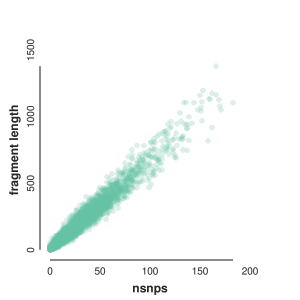

In [10]:
toyplot.config.autoformat = "png"
toyplot.scatterplot(
    simi5.tree_table.nsnps, 
    simi5.tree_table.length,
    width=300, height=300,
    opacity=0.25,
    xlabel='nsnps', ylabel='fragment length',
);

In [14]:
toyplot.config.autoformat = "html"
canvas = toyplot.Canvas(width=350, height=300)
axes = canvas.cartesian(xlabel="fragment length")
axes.bars(
    np.histogram(simi5.tree_table.length),
);

0 500 1000 1500 fragment length 0 1000 2000 3000 4000

### Measure clade support along chromosome

In [15]:
def map_node_colors(ttree):
    ncolors = ttree.get_node_values('idx')
    cidx = 0
    for i in range(len(ncolors)):
        if i in ncolors:
            nidx = ncolors.index(i)
            ncolors[nidx] = toytree.colors[cidx]
            cidx += 1
    return ncolors

In [28]:
def tree_clades_slider_plot(self):
    canvas = toyplot.Canvas(width=500, height=550)
    ax0 = canvas.cartesian(bounds=(75, 425, 50, 250))
    ax1 = canvas.cartesian(bounds=(50, 450, 300, 500), xlabel="Genomic position (Mb)")

    self.tree.draw(
        axes=ax0,
        orient='down', 
        node_sizes=17,
        node_labels=self.tree.get_node_values("idx"),
        node_style={"stroke": "#262626", "fill-opacity": 0.9},
        node_colors=map_node_colors(self.tree),
        tip_labels=False,
    )

    breakpoints = self.tree_table.start
    base = np.zeros(breakpoints.size, dtype=int)
    for col in self.clade_table:
        ax1.fill(
            a=breakpoints,
            b=base, 
            c=base + self.clade_table[col].astype(int), 
            opacity=0.9,
        )
        base += 1

    # styling
    ax0.show = False
    ax1.y.ticks.locator = toyplot.locator.Explicit(
        locations=np.arange(0, 6) + 0.5,
        labels=range(8, 14),
    )
    ax1.x.ticks.locator = toyplot.locator.Explicit(
        locations=np.linspace(0, 1000000, 10),
        labels=range(0, 10),
    )
    ax1.x.ticks.show = True
    ax1.y.ticks.labels.angle = -90
    return canvas, (ax0, ax1)

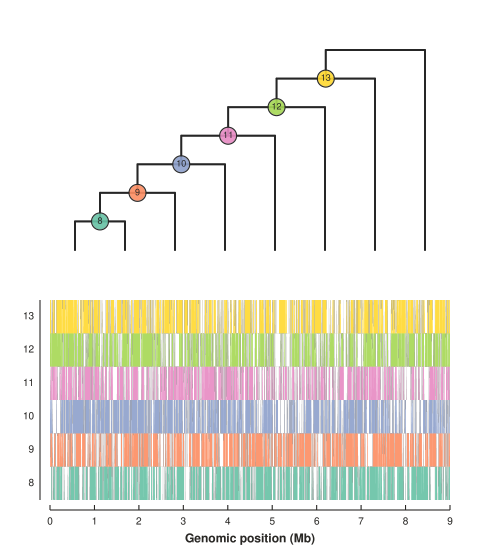

In [29]:
canvas, axes = tree_clades_slider_plot(simi5)
toyplot.html.render(canvas, "../figures/imbalanced_5.html")
toyplot.pdf.render(canvas, "../figures/imbalanced_5.pdf")
canvas

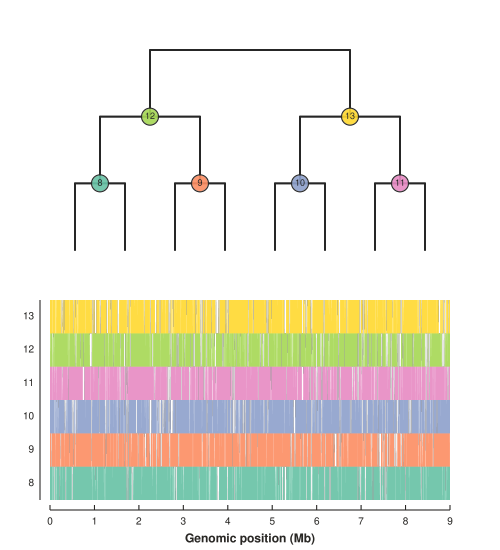

In [30]:
canvas, axes = tree_clades_slider_plot(simb5)
toyplot.html.render(canvas, "../figures/balanced_5.html")
toyplot.pdf.render(canvas, "../figures/balanced_5.pdf")
canvas

### How large are contiguous clade supporting fragments?

In [63]:
def get_clade_lengths(self, cidx):
    lengths = []
    flen = 0
    for idx in self.clade_table.index:
        # extend fragment
        if self.clade_table.loc[idx, cidx] == 1:
            flen += 1
        # terminate fragment
        else:
            if flen:
                lengths.append(flen)
                flen = 0
    return np.array(lengths)

In [64]:
for node in simi5.tree.treenode.traverse():
    if not node.is_leaf() and not node.is_root():
        flens = get_clade_lengths(simi5, node.idx)
        print("{}\t{:.2f}\t{:.2f}".format(node.idx, flens.mean(), flens.std()))

13	13.28	16.97
12	14.82	19.40
11	11.45	13.15
10	14.45	18.65
9	16.72	19.46
8	17.17	19.87


In [67]:
c, a = toyplot.bars(np.histogram(flens), width=300, height=300);

0 40 80 120 0 40 80 120

In [ ]:
    # toyplot.html.render(canvas, "../figures/imbalanced_5.html")
    # toyplot.pdf.render(canvas, "../figures/imbalanced_5.pdf")

In [25]:
canvas = toyplot.Canvas(width=500, height=550)
ax0 = canvas.cartesian(bounds=(75, 425, 50, 250))
ax1 = canvas.cartesian(bounds=(50, 450, 300, 500), xlabel="Genomic position (Mb)")

self = simi5

self.tree.draw(
    axes=ax0,
    orient='down', 
    node_sizes=17,
    node_labels=self.tree.get_node_values("idx"),
    node_style={"stroke": "#262626", "fill-opacity": 0.9},
    node_colors=map_node_colors(self.tree),
    tip_labels=False,
)

breakpoints = self.tree_table.start
base = np.zeros(breakpoints.size, dtype=int)
for col in self.clade_table:
    ax1.fill(
        a=breakpoints,
        b=base, 
        c=base + self.clade_table[col].astype(int), 
        opacity=0.9,
    )
    base += 1
    
# styling
ax0.show = False
ax1.y.ticks.locator = toyplot.locator.Explicit(
    locations=np.arange(0, 6) + 0.5,
    labels=range(8, 14),
)
ax1.x.ticks.locator = toyplot.locator.Explicit(
    locations=np.linspace(0, 1000000, 10),
    labels=range(0, 10),
)
ax1.x.ticks.show = True
ax1.y.ticks.labels.angle = -90

# toyplot.html.render(canvas, "../figures/imbalanced_5.html")
# toyplot.pdf.render(canvas, "../figures/imbalanced_5.pdf")

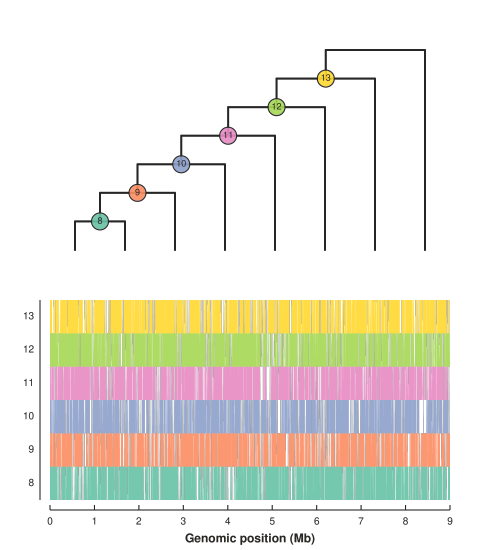

In [23]:
canvas

### Simulate sequences on the genealogies
This is the result after `Coalseq.get_sequences()` called by `__init__`. 

For the purposes of this, we actually don't need to write out the sequences. That saves us some time.

In [ ]:
#sim.write_seqs()

In [ ]:
#sim.build_seqs(hdf5=True)

Instead, we will now use "write_clades()" which will make a new "clades" directory with as many files as we have gene trees. In each file will be a list of clades for that particular gene tree.

In [ ]:
sim.write_clades()

Now we're going to ask about the persistence of each clade, in an exploratory way. So first: how many clades are there among all the gene trees?

In [ ]:
full_list = []
for i in os.listdir('testdir/clades/'):
    with open('testdir/clades/'+i,'r') as f:
        data=f.read().splitlines()
    test = [sorted(ast.literal_eval(i)) for i in data]
    full_list.extend(test)
    full_list = list(np.unique(full_list))

Show some of them

In [ ]:
full_list[0:10]

How many total?

In [ ]:
len(full_list)

Wow -- a lot.

Let's sort the list by clade size -- just for fun.

In [ ]:
full_list=np.array(full_list)[np.argsort([len(i) for i in full_list])]

In [ ]:
full_list

Now, we'd love to go through and say which of these clades (by index) are present in which gene trees.

In [ ]:
@jit
def get_equal_list(big_list,little_list):
    for i in range(len(big_list)):
        if big_list[i] == little_list:
            return(i)

Now make a huge array to contain all of the presence vs. absence of particular clades...

In [ ]:
clade_pres = np.zeros((len(full_list),len(os.listdir('testdir/clades/'))),dtype=np.int8)

In [ ]:
clade_pres.shape

So here, each row corresponds to a clade. Each column is a consecutive gene tree. And since we sorted the clades by length, the shorter clades (e.g. of two taxa) will be near the top, and the longer clades (e.g. of 12 taxa) will be near the bottom of the array.

We'll change a cell from 0 to 1 if that clade (row) is present in that gene tree (col).

In [ ]:
for i in range(len(os.listdir('testdir/clades/'))):
    with open('testdir/clades/'+str(i)+'.txt','r') as f:
        data=f.read().splitlines()
    test = [sorted(ast.literal_eval(dat)) for dat in data]
    for clade in test:
        row = get_equal_list(full_list,clade)
        clade_pres[row,i] = 1

Now we have a huge numpy array where each column corresponds to a particular gene tree, and each row corresponds to a possible clade. Cells with "1" in this array indicate that the particular clade is found in the particular gene tree.

We can visualize this using toyplot matrix:

In [ ]:
toyplot.matrix(clade_pres[10:20,0:1000],width = 1300, height = 300);

So you can see that some particular clades tend to be present in a lot of consecutive gene trees (they aren't split up too often)